В этом задании вам предлагается проанализировать данные одной из американских телекоммуникационных компаний о пользователях, которые потенциально могут уйти.

In [2]:
import pandas as pd
import numpy as np

In [161]:
Data = pd.read_csv('churn_analysis.csv')

In [162]:
Data.head()

,Unnamed: 0,state,account_length,area_code,intl_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,...,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,custserv_calls,treatment,mes_estim,churn
0,0,KS,128,415,no,yes,25,265.1,110,45.07,...,244.7,91,11.01,10.0,3,2.70,1,1,0.65,False.
1,1,OH,107,415,no,yes,26,161.6,123,27.47,...,254.4,103,11.45,13.7,3,3.70,1,0,0.55,False.
2,2,NJ,137,415,no,no,0,243.4,114,41.38,...,162.6,104,7.32,12.2,5,3.29,0,0,0.72,False.
3,3,OH,84,408,yes,no,0,299.4,71,50.90,...,196.9,89,8.86,6.6,7,1.78,2,1,0.28,False.
4,4,OK,75,415,yes,no,0,166.7,113,28.34,...,186.9,121,8.41,10.1,3,2.73,3,2,0.45,False.


state — штат США

account_length — длительность использования аккаунта

area_code — деление пользователей на псевдорегионы, использующееся в телекоме

intl_plan — подключена ли у пользователя услуга международного общения

vmail_plan — подключена ли у пользователя услуга голосовых сообщений

vmail_message — количество голосых сообщений, который пользователь отправил / принял

day_calls — сколько пользователь совершил дневных звонков

day_mins — сколько пользователь проговорил минут в течение дня

day_charge — сколько пользователь заплатил за свою дневную активность

eve_calls, eve_mins, eve_charge — аналогичные метрики относительно вечерней активности

night_calls, night_mins, night_charge — аналогичные метрики относительно ночной активности

intl_calls, intl_mins, intl_charge — аналогичные метрики относительно международного общения

custserv_calls — сколько раз пользователь позвонил в службу поддержки

treatment — номер стратегии, которая применялись для удержания абонентов (0, 2 = два разных типа воздействия, 1 = контрольная 
группа)

mes_estim — оценка интенсивности пользования интернет мессенджерами

churn — результат оттока: перестал ли абонент пользоваться услугами оператора


Давайте рассмотрим всех пользователей из контрольной группы (treatment = 1). Для таких пользователей мы хотим проверить гипотезу о том, что штат абонента не влияет на то, перестанет ли абонент пользоваться услугами оператора.

In [163]:
data = Data[Data['treatment'] == 1]

In [164]:
d = {'state':dict(data['state'].value_counts()).keys() , 'sum': dict(data['state'].value_counts()).values()}

In [165]:
states_all = pd.DataFrame(data=d)


In [166]:
data.churn.value_counts()

False.    917
True.     180
Name: churn, dtype: int64

In [167]:
data['True']=data['churn'].apply(lambda x : 1 if x == 'True.'  else 0)

C:\Users\Nastya\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [168]:
states_data = data[['state','True']].groupby(['state']).sum()

In [169]:
new_data = pd.merge(states_data, states_all, on='state', how='outer')

In [170]:
new_data.head()

,state,True,sum
0,AK,1,20
1,AL,5,30
2,AR,5,16
3,AZ,2,19
4,CA,5,15


In [171]:
new_data['False'] = new_data['sum'] - new_data['True']

In [172]:
new_data.head()

,state,True,sum,False
0,AK,1,20,19
1,AL,5,30,25
2,AR,5,16,11
3,AZ,2,19,17
4,CA,5,15,10


In [173]:
import scipy.stats

## 1.Критерий Хи-квадрат (проверяем, что две дискретные случайные величины принадлежат одному расспределению).

In [175]:
p_values = []
for i in range(51):
    for j in range(51):
        if j>=i:
            continue
        p_values.append(scipy.stats.chi2_contingency([[new_data['True'][i],new_data['False'][i]],[new_data['True'][j],new_data['False'][j]]], correction=False)[1])

Посмотрим, сколько достигаемых уровней значимости меньше 0.05.

In [223]:
p_value_smaller = [x for x in p_values if x<0.05]

In [224]:
len(p_value_smaller)

34

В основе критерия xи-квадрат лежит предположение о том, что если верна нулевая гипотеза, то дискретное биномиальное распределение данных по клеткам в таблице сопряженности может быть аппроксимировано с помощью непрерывного распределения xи-квадрат. Однако точность такой аппроксимации существенно зависит от суммарного количества наблюдений и их распределения в этой таблице (отсюда и ограничения при использовании критерия xи-квадрат).

Одним из способов коррекции точности аппроксимации является поправка Йетса на непрерывность.

In [208]:
p_values_1 = []
for i in range(51):
    for j in range(51):
        if j>=i:
            continue
        p_values_1.append(scipy.stats.chi2_contingency([[new_data['True'][i],new_data['False'][i]],[new_data['True'][j],new_data['False'][j]]], correction=True)[1])

In [212]:
scipy.stats.chi2_contingency([[new_data['True'][2],new_data['False'][2]],[new_data['True'][1],new_data['False'][1]]], correction=True)

(0.5880439814814814, 0.4431764972638791, 1L, array([[ 3.47826087, 12.52173913],
        [ 6.52173913, 23.47826087]]))

In [214]:
p_values_1[2]

0.4431764972638791

In [215]:
[x for x in p_values_1 if x<0.05]

[]

In [216]:
len(p_value_smaller_1)

0

In [217]:
len([x for x in zip(p_values_1,p_values) if x[0]>x[1]])

1054

Следовательно, не все достигаемые уровни значимости стали больше, но в среднем это так.

## 2. Применяем критерий Фишера.

In [219]:
p_values_f = []
for i in range(51):
    for j in range(51):
        if j>=i:
            continue
        p_values_f.append(scipy.stats.fisher_exact([[new_data['True'][i],new_data['False'][i]],[new_data['True'][j],new_data['False'][j]]])[1])

In [221]:
p_values_f_smaller=[x for x in p_values_f if x<0.05]

In [222]:
len(p_values_f_smaller)

10

Сравним полученные результаты с достигаемыми уровнями значимости, получанными с помощью критерия согласия Пирсона:

In [226]:
len([x for x in zip(p_values_f,p_values) if x[0]>x[1]])

1247

## 3. Корреляция.

In [231]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Рассмотрим пару признаков day_calls и mes_estim. Посчитаем корреляцию Пирсона между этими признаками на всех данных, ее значимость.

In [235]:
scipy.stats.pearsonr(Data['day_calls'], Data['mes_estim'])

(-0.051794350587572625, 0.0027798836869756707)

((array([-3.5297919 , -3.28786833, -3.15418238, ...,  3.15418238,
          3.28786833,  3.5297919 ]),
  array([  0,   0,  30, ..., 160, 163, 165], dtype=int64)),
 (20.06326629015901, 100.43564356435644, 0.998901696930286))

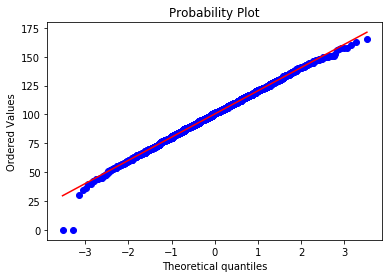

In [236]:
scipy.stats.probplot(Data['day_calls'], dist="norm", plot=pylab)

((array([-3.5297919 , -3.28786833, -3.15418238, ...,  3.15418238,
          3.28786833,  3.5297919 ]),
  array([0.05, 0.05, 0.05, ..., 0.89, 0.91, 0.96])),
 (0.13861708020693375, 0.4842364236423642, 0.9996050483985336))

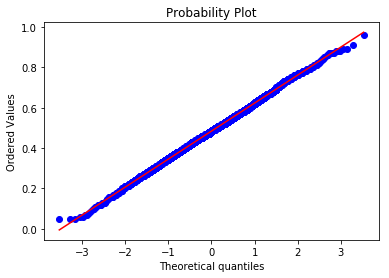

In [237]:
scipy.stats.probplot(Data['mes_estim'], dist="norm", plot=pylab)

In [238]:
scipy.stats.spearmanr(Data['day_calls'], Data['mes_estim'])

SpearmanrResult(correlation=0.043349880533927444, pvalue=0.012317367189170541)

## 4. Анализируем эффективность двух стратегий (treatment = 0/2)

In [355]:
data_first = Data[Data.treatment == 0]['churn'].apply(lambda x: 1 if x == 'True.' else 0)
data_second = Data[Data.treatment == 2]['churn'].apply(lambda x: 1 if x == 'True.' else 0)

In [246]:
data_first.value_counts()

False.    968
True.     165
Name: churn, dtype: int64

In [247]:
data_second.value_counts()

False.    965
True.     138
Name: churn, dtype: int64

Обучим линейный классификатор и посмотрим на результат его работы на контрольной выборке:

In [305]:
import sklearn.linear_model
import sklearn.metrics 

In [261]:
Data.columns

Index([u'Unnamed: 0', u'state', u'account_length', u'area_code', u'intl_plan',
       u'vmail_plan', u'vmail_message', u'day_mins', u'day_calls',
       u'day_charge', u'eve_mins', u'eve_calls', u'eve_charge', u'night_mins',
       u'night_calls', u'night_charge', u'intl_mins', u'intl_calls',
       u'intl_charge', u'custserv_calls', u'treatment', u'mes_estim',
       u'churn'],
      dtype='object')

In [310]:
X_train_1 = Data[Data.treatment == 0].drop('churn',axis = 1)

In [311]:
X_test = Data[Data.treatment == 1].drop('churn',axis = 1)
y_train_1 = Data[Data.treatment == 0]['churn'].apply(lambda x: 1 if x == 'True.' else 0)
y_test = Data[Data.treatment == 1]['churn'].apply(lambda x: 1 if x == 'True.' else 0)
y_train_2 = Data[Data.treatment == 2]['churn'].apply(lambda x: 1 if x == 'True.' else 0)
X_train_2 = Data[Data.treatment == 2].drop('churn',axis = 1)

In [313]:
X_train_1['intl_plan'] = X_train_1['intl_plan'].apply(lambda x: 1 if x == 'yes' else 0)
X_train_1['vmail_plan'] = X_train_1['vmail_plan'].apply(lambda x: 1 if x == 'yes' else 0)
X_train_2['intl_plan'] = X_train_2['intl_plan'].apply(lambda x: 1 if x == 'yes' else 0)
X_train_2['vmail_plan'] = X_train_2['vmail_plan'].apply(lambda x: 1 if x == 'yes' else 0)

In [314]:
reg = sklearn.linear_model.RidgeClassifier()

In [315]:
reg.fit(X_train_1.drop('state', axis =1),y_train_1)

RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='auto',
        tol=0.001)

In [320]:
X_test['intl_plan'] = X_test['intl_plan'].apply(lambda x: 1 if x == 'yes' else 0)
X_test['vmail_plan'] = X_test['vmail_plan'].apply(lambda x: 1 if x == 'yes' else 0)

In [321]:
reg.predict(X_test.drop('state', axis =1))

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [322]:
sklearn.metrics.accuracy_score(y_test,reg.predict(X_test.drop('state', axis =1)))

0.8359161349134002

In [323]:
classifier = sklearn.linear_model.SGDClassifier(loss = 'log', random_state = 1)

In [324]:
classifier.fit(X_train_1.drop('state', axis =1),y_train_1)

C:\Users\Nastya\Anaconda2\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=1, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [325]:
sklearn.metrics.accuracy_score(y_test,classifier.predict(X_test.drop('state', axis =1)))

0.837739288969918

In [327]:
from sklearn import ensemble

In [347]:
rf_classifier = ensemble.RandomForestClassifier(n_estimators = 200, max_depth = 10, random_state = 1)

In [348]:
rf_classifier.fit(X_train_1.drop('state', axis =1),y_train_1)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [349]:
sklearn.metrics.accuracy_score(y_test,rf_classifier.predict(X_test.drop('state', axis =1)))

0.8969917958067457

In [350]:
rf_classifier.predict(X_test.drop('state', axis =1)).sum()

79

In [351]:
rf_classifier_2 = ensemble.RandomForestClassifier(n_estimators = 200, max_depth = 10, random_state = 1)

In [352]:
rf_classifier_2.fit(X_train_2.drop('state', axis =1),y_train_2)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [353]:
sklearn.metrics.accuracy_score(y_test,rf_classifier_2.predict(X_test.drop('state', axis =1)))

0.8851412944393802

In [354]:
rf_classifier_2.predict(X_test.drop('state', axis =1)).sum()

84

(этого всего делать не надо было))))))))))))))
просто проверяем нулевую гипотезу о том, что treatment =0 статистически значимо.


In [356]:
scipy.stats.ttest_ind(data_first,y_test)

Ttest_indResult(statistic=-1.2045205230813099, pvalue=0.2285163910842895)

In [357]:
scipy.stats.ttest_ind(data_second,y_test)

Ttest_indResult(statistic=-2.601870748565941, pvalue=0.009333926332475618)

In [358]:
scipy.stats.ttest_ind(data_second,data_first)

Ttest_indResult(statistic=-1.4172019054376395, pvalue=0.15656334748097409)